<a href="https://colab.research.google.com/github/Satyadev-Patel/ClusteringGroupOfMachines/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Group of Machines

### Dataset Used - 
 http://gwa.ewi.tudelft.nl/datasets/gwa-t-13-materna

In [2]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#unzip the data file
!unzip -q '/content/drive/My Drive/GWA-T-13_Materna-Workload-Traces.zip'

### Import Libraries

In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from numpy import unique
from numpy import where
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS
from sklearn.model_selection import GridSearchCV


In [5]:
#List of input data folder i.e. Materna-Trace-1, Materna-Trace-2, Materna-Trace-3
Materna_Traces = ['/content/GWA-T-13_Materna-Workload-Traces/Materna-Trace-1', 
        '/content/GWA-T-13_Materna-Workload-Traces/Materna-Trace-2',
        '/content/GWA-T-13_Materna-Workload-Traces/Materna-Trace-3']

### Data Cleaning and Reading

In [6]:
def dataset_cleaning(dataset_path):
  def readInputData(paths):
    #iterate each data folder
    for path in paths:
      #All csv files in current data folder
      all_files = glob.glob(path + "/*.csv")
      
      data = []
      for filename in all_files:
          #read each csv file
          df = pd.read_csv(filename, delimiter=';', index_col=None, header=0)
          #append the data
          data.append(df)
      #merge the data and make dataframe
      dataframe = pd.concat(data, axis=0, ignore_index=True)
    return dataframe
  #call the function
  inputData = readInputData(dataset_path)
  df = inputData
  cool = list(df.columns)
  if 'CPU usage [MHZ]' in cool and 'Disk read throughput [KB/s]' in cool and 'Disk write throughput [KB/s]':

    df = df.drop('Timestamp', axis=1)
    #replace , with . in % values
    df = df.replace(to_replace=r',', value='.', regex=True)
    machine_data_index = np.random.randint(1, df.shape[0], 10000)
    df['CPU usagelog'] = np.log(df['CPU usage [MHZ]'])
    return df
  else:
    print("Your dataset does not contain columns such as ''Disk write throughput [KB/s]','CPU usage [MHZ],'Disk read throughput [KB/s]''. If similar features exists in the dataset then rename it to the given column names")
                            

### Making a small dataset for training prupose

In [7]:
new_data = dataset_cleaning(Materna_Traces)
def training_dataset(data):
  df = data
  cpu_mem_disk_NW_use_data = df[['CPU usagelog',
                                        'Disk read throughput [KB/s]',
                                        'Disk write throughput [KB/s]']]
  #standard scale data                          
  cpu_mem_disk_NW_use_data_std = StandardScaler().fit_transform(cpu_mem_disk_NW_use_data)
  #randomly choose ten thousand samples
  return cpu_mem_disk_NW_use_data_std
cpu_mem_disk_NW_use_data_std = training_dataset(new_data)
machine_data_index = np.random.randint(1, new_data.shape[0], 10000)

### Selecting the Best Algorithm

In [19]:
def clustering_algo_selection(dataset):
  def algorithms(dataset):
    kmeans_2cluster = 0
    kmeans_3cluster = 0
    kmeans_4cluster = 0
    dbscore_1 = 0
    dbscore_2 = 0
    dbscore_3 = 0
    agg_2cluster = 0
    agg_3cluster = 0
    agg_4cluster = 0
    mbk_2cluster = 0
    mbk_3cluster = 0
    mbk_4cluster = 0
    shift_score1 = 0

    def score(data,n_c): 
      kmeans_model = KMeans(n_clusters=n_c, random_state=1).fit(data)
      labels = kmeans_model.labels_
      x = metrics.silhouette_score(data, labels, metric='euclidean')
      return x
    
    kmeans_2cluster = score(dataset,2)
    kmeans_3cluster = score(dataset,3)
    kmeans_4cluster = score(dataset,4)
    def dbscore(data,x):
      db = DBSCAN(eps=x, min_samples=100).fit(dataset)
      labels = db.labels_
      x = metrics.silhouette_score(data, labels, metric='euclidean')
      return x
    dbscore_1 = dbscore(dataset,0.2)
    dbscore_2 = dbscore(dataset,0.5)
    dbscore_3 = dbscore(dataset,0.7)
    def aggscore(data,damp):
      model = AgglomerativeClustering(n_clusters=damp)
      # fit the model
      model.fit(data)
      labels = model.labels_
      x = metrics.silhouette_score(data, labels, metric='euclidean')
      return x
    agg_2cluster = aggscore(dataset,2)
    agg_3cluster = aggscore(dataset,3)
    agg_4cluster = aggscore(dataset,4)
    def minbatchkmeans_score(data,n):
      model = MiniBatchKMeans(n)
      # fit the model
      model.fit(data)
      # assign a cluster to each example
      labels = model.labels_
      x = metrics.silhouette_score(data, labels,metric = 'euclidean')
      return x
    mbk_2cluster = minbatchkmeans_score(dataset,2)
    mbk_3cluster = minbatchkmeans_score(dataset,3)
    mbk_4cluster = minbatchkmeans_score(dataset,4)
    def shift_score(data):
      model = MeanShift()
      # fit the model
      model.fit(data)
      # assign a cluster to each example
      labels = model.labels_
      x = metrics.silhouette_score(data, labels,metric = 'euclidean')
      return x
    shift_score1 = shift_score(dataset)
    def opticscore(data,x):
      model = OPTICS(x,10).fit(dataset)
      labels = model.labels_
      x = metrics.silhouette_score(data, labels, metric='euclidean')
      return x
    optics_score = opticscore(dataset,0.5)
    results = {'kmeans 2 cluster':[kmeans_2cluster],
              'kmeans 3 cluster':[kmeans_3cluster],
              'kmeans 4 cluster':[kmeans_4cluster],
              'dbscan for eps = 0.2':[dbscore_1],
              'dbscan for eps = 0.5':[dbscore_2],
              'dbscan for eps = 0.7':[dbscore_3],
              'agg clustering for 2 cluster':[agg_2cluster],
              'agg clustering for 3 cluster':[agg_3cluster],
              'agg clustering for 4 cluster':[agg_4cluster],
              'mbk for 2 cluster':[mbk_2cluster],
              'mbk for 3 cluster':[mbk_3cluster],
              'mbk for 4 cluster':[mbk_4cluster],
              'mean shifting':[shift_score1],
              'OPTICS':[optics_score]}
    for i in results:
      print(i,":",results[i])
    Keymax = max(results, key=results.get) 
    print(Keymax,"has the highest accuracy")
  algorithms(dataset)
clustering_algo_selection(cpu_mem_disk_NW_use_data_std[machine_data_index])

kmeans 2 cluster : [0.9204648644318795]
kmeans 3 cluster : [0.9200063829598637]
kmeans 4 cluster : [0.5656539970958735]
dbscan for eps = 0.2 : [0.6889275158848369]
dbscan for eps = 0.5 : [0.7937764313410723]
dbscan for eps = 0.7 : [0.8250725238672628]
agg clustering for 2 cluster : [0.9095224017650707]
agg clustering for 3 cluster : [0.9120878950811752]
agg clustering for 4 cluster : [0.5174247932897604]
mbk for 2 cluster : [0.9161802345947657]
mbk for 3 cluster : [0.49022822702719715]
mbk for 4 cluster : [0.5553638132230966]
mean shifting : [0.32759126113403575]
OPTICS : [0.9436354381776973]
OPTICS has the highest accuracy


### Hyper-Parameter tuning of the Best Algorithm that we found earlier

In [22]:
def optics_func(data,x,maxeps):
  model = OPTICS(x,maxeps)
  yhat = model.fit_predict(data)
  m = unique(yhat)
  plt.figure(figsize = (8,6))
  for cluster in m:
    # get row indexes for samples with this cluster
    row_ix = where(yhat == cluster)
    # create scatter of these samples
    plt.scatter(data[row_ix, 0], data[row_ix, 1])
    #add title for a plot 
    plt.title("min_sample="+str(int(x*10000))+"    "+"eps = "+str(maxeps))
  # show the plot
  plt.show()
def hyperparameter_tuning(model,data):
  def score_optics(model,data):
    yhat = model.fit_predict(data)
    m = unique(yhat)
    score = metrics.silhouette_score(data, model.labels_, metric='euclidean')
    return score
  param_grid = {"min_samples": [0.5,0.4,0.3,0.25],"max_eps":[8,9,10]}
  search = GridSearchCV(ca,param_grid,scoring = score_optics)
  search.fit(data)
  k = 0
  minsamp = [0 for i in range(12)]
  maxeps = [0 for i in range(12)]
  result = [0 for i in range(12)]
  for i in search.cv_results_['params']:
    minsamp[k] = i.get('min_samples')
    maxeps[k] = i.get('max_eps')
    result[k] = search.cv_results_['mean_test_score'][k]
    k += 1
    final_results = {
      'Min Samples':minsamp,
      'MAX Epsilon':maxeps,
      'Final Score':result
  }
  final = pd.DataFrame (final_results, columns = ['Min Samples','MAX Epsilon','Final Score'])
  return final
ca = OPTICS()
final_scores = hyperparameter_tuning(ca,cpu_mem_disk_NW_use_data_std[machine_data_index])

### Printing the best results

In [27]:
z = final_scores['Final Score'].idxmax(0)
print("BEST PARAMETERS")
print("Min Samples:",final_scores['Min Samples'][z])
print("MAX Epsilon:",final_scores['MAX Epsilon'][z])
print("Accuracy:",final_scores['Final Score'][z])

BEST PARAMETERS
Min Samples: 0.4
MAX Epsilon: 10
Accuracy: 0.9421693013909603


### Appyling the Algorithm with the parameters that we found earlier

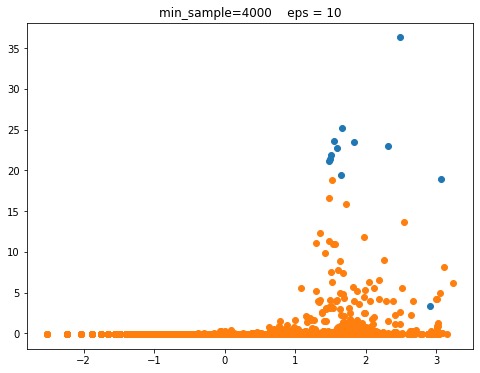

In [30]:
optics_func(cpu_mem_disk_NW_use_data_std[machine_data_index],final_scores['Min Samples'][z],final_scores['MAX Epsilon'][z])